In [1]:
import pandas as pd
import sqlite3
import os
import statsmodels.api as sm
import pylab as pl
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from muscularityplotting import plot_validation_data, plot_hist_by_sport, make_sport_pie_chart
from ExtractData import ExtractData

/Users/amywinecoff/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
data_path = '/Users/amywinecoff/Documents/sport_body_project/sport_body_project/data'
os.chdir(data_path)

db_connect = ExtractData('muscularity_sqlite.db')

ht_wt_bmi = db_connect.select_from_table('ht_wt_bmi')
body_decisions = db_connect.select_from_table('body_decisions')
body_image_values = db_connect.select_from_table('body_image_values')
demographics = db_connect.select_from_table('demographics')
validation = db_connect.select_from_table('body_image_validation')

db_connect.close_connection()


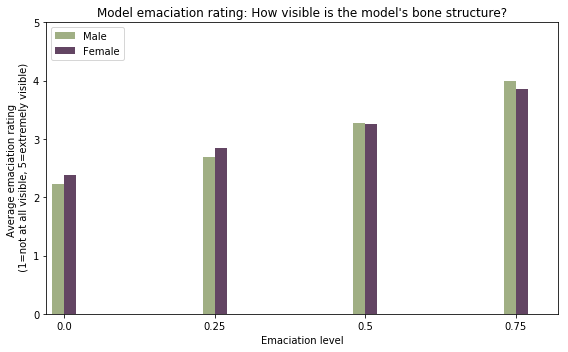

In [7]:
plot_validation_data(validation, 'emaciation')

In [8]:
demographics = demographics[['subj', 'sport', 'gender', 'age', 'education', 'race', 'frequency', 'duration', 'percent women']]
demographics_plus = pd.merge(demographics, ht_wt_bmi, on='subj', how='left').dropna()
demographics_plus['BMI'] = pd.to_numeric(demographics_plus['BMI'],errors='coerce').round(1)#round BMI so it can be more easily plotted later
demographics_plus = demographics_plus[(demographics_plus['BMI'] > 14) & (demographics_plus['BMI'] < 35)]#remove implausible BMI values
demographics_plus.sort_values('BMI', ascending=True)

,subj,sport,gender,age,education,race,frequency,duration,percent women,ht_in,wt_lb,BMI
848,1112,Rock climbing,Female,53.0,18,Asian,Three days a week,1-3 years,Less than 25%,64.0,95,16.3
125,1023,Rock climbing,Female,24.0,17,"White, Caucasian",Three days a week,10 or more years,Less than 25%,70.0,115,16.5
550,1050,Rock climbing,Female,33.0,16,"White, Caucasian",Three days a week,10 or more years,About 75%,64.0,97,16.6
14,4110,Rock climbing,Male,19.0,12,"White, Caucasian",Five days a week,7-9 years,About 50%,71.5,123,16.9
506,1072,Rock climbing,Female,32.0,20,"White, Caucasian",Five days a week,10 or more years,Less than 25%,72.0,126,17.1
835,1133,Rock climbing,Female,51.0,16,Asian,Two days a week,10 or more years,About 25%,64.0,100,17.2
490,4116,Rock climbing,Male,31.0,16,"White, Caucasian",Three days a week,1-3 years,About 50%,70.0,120,17.2
250,3045,Running,Female,27.0,20,"White, Caucasian",Six days a week,7-9 years,About 25%,67.0,110,17.2
729,1104,Rock climbing,Female,40.0,16,"White, Caucasian",Three days a week,7-9 years,About 50%,69.0,117,17.3
427,2027,CrossFit,Female,30.0,16,"White, Caucasian",Three days a week,1-3 years,About 50%,58.0,83,17.3


In [9]:
body_decisions_long=pd.melt(body_decisions,id_vars=['subj'],var_name='body_num', value_name='choice').sort_values(['subj'])
body_decisions_long.head(5)
#body_image_values.head(5)

,subj,body_num,choice
31686,1000,body36,Right
17462,1000,body20,Right
47688,1000,body54,Left
10350,1000,body12,Right
25463,1000,body29,Right


In [11]:
body_choice_df = pd.merge(body_decisions_long, body_image_values, on='body_num', how='left')
body_choice_df = pd.merge(body_choice_df, demographics_plus, on='subj',how='left')

body_choice_df.loc[:,'chose_ref'] = [1 if x == y else 0 for x,y in zip(body_choice_df['ref_side'], body_choice_df['choice'])] 
body_choice_df.loc[:,'chose_test'] = [1 if x != y else 0 for x,y in zip(body_choice_df['ref_side'], body_choice_df['choice'])] 
body_choice_df.head(5)

,subj,body_num,choice,detail,emaciation,size,test_jpg,ref_side,sport,gender,...,education,race,frequency,duration,percent women,ht_in,wt_lb,BMI,chose_ref,chose_test
0,1000,body36,Right,0.50,0.00,0.25,55_BBD0.5_BBS0.25_E0.jpg,Left,Rock climbing,Female,...,16.0,"White, Caucasian",Three days a week,7-9 years,About 25%,68.0,135,20.5,0,1
1,1000,body20,Right,0.25,0.00,0.25,30_BBD0.25_BBS0.25_E0.jpg,Right,Rock climbing,Female,...,16.0,"White, Caucasian",Three days a week,7-9 years,About 25%,68.0,135,20.5,1,0
2,1000,body54,Left,0.75,0.50,0.25,82_BBD0.75_BBS0.25_E0.5.jpg,Right,Rock climbing,Female,...,16.0,"White, Caucasian",Three days a week,7-9 years,About 25%,68.0,135,20.5,0,1
3,1000,body12,Right,0.00,0.00,0.75,15_BBD0_BBS0.75_E0.jpg,Left,Rock climbing,Female,...,16.0,"White, Caucasian",Three days a week,7-9 years,About 25%,68.0,135,20.5,0,1
4,1000,body29,Right,0.25,0.25,0.75,41_BBD0.25_BBS0.75_E0.25.jpg,Left,Rock climbing,Female,...,16.0,"White, Caucasian",Three days a week,7-9 years,About 25%,68.0,135,20.5,0,1


In [14]:
pd.DataFrame.to_csv(body_choice_df, 'data_for_R_glm.csv', index=False)

In [ ]:
plot_hist_by_sport(demographics_plus, 'education', 10)

In [ ]:
make_sport_pie_chart(demographics_plus, 'Rock climbing', 'percent women')

In [ ]:
model_data_all = body_choice_df.dropna()
model_data_all.head(5)

In [ ]:
print("Length of df for all is {}".format(len(model_data_all)))
model_data_female = model_data_all[model_data_all['gender']=='Female']
model_data_male = model_data_all[model_data_all['gender']=='Male']

#Use running as the reference group
female_mod_run =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Running'))*size + C(sport, Treatment(reference='Running'))*detail + C(sport, Treatment(reference='Running'))*emaciation + C(sport, Treatment(reference='Running'))*age", data = model_data_female)
male_mod_run =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Running'))*size + C(sport, Treatment(reference='Running'))*detail + C(sport, Treatment(reference='Running'))*emaciation + C(sport, Treatment(reference='Running'))*age", data = model_data_male)



f_result_run = female_mod_run.fit()
m_result_run = male_mod_run.fit()




In [ ]:
print (f_result_run.summary())

In [ ]:
female_mod_rc =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Rock climbing'))*size + C(sport, Treatment(reference='Rock climbing'))*detail + C(sport, Treatment(reference='Rock climbing'))*emaciation + C(sport, Treatment(reference='Rock climbing'))*age", data = model_data_female)
male_mod_rc =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='Rock climbing'))*size + C(sport, Treatment(reference='Rock climbing'))*detail + C(sport, Treatment(reference='Rock climbing'))*emaciation + C(sport, Treatment(reference='Rock climbing'))*age", data = model_data_male)

female_mod_cf =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='CrossFit'))*size + C(sport, Treatment(reference='CrossFit'))*detail + C(sport, Treatment(reference='CrossFit'))*emaciation + C(sport, Treatment(reference='CrossFit'))*age", data = model_data_female)
male_mod_cf =smf.logit(formula = "chose_test ~ C(sport, Treatment(reference='CrossFit'))*size + C(sport, Treatment(reference='CrossFit'))*detail + C(sport, Treatment(reference='CrossFit'))*emaciation + C(sport, Treatment(reference='CrossFit'))*age", data = model_data_male)

f_result_rc = female_mod_rc.fit()
m_result_rc = male_mod_rc.fit()

f_result_run = female_mod_cf.fit()
m_result_run = male_mod_cf.fit()

In [ ]:
print (f_result_rc.summary())

In [ ]:
#TODO: Add in plotting for the association between regression coefficients and predicted probability